In [1]:
from __future__ import print_function
# if our large test file is available, use it. Otherwise, use file generated from toy_mstis_2_run.ipynb
import os
test_file = "../toy_mstis_1k_OPS1.nc"
filename = test_file if os.path.isfile(test_file) else "mstis.nc"
print("Using file `"+ filename + "` for analysis")

Using file `../toy_mstis_1k_OPS1.nc` for analysis


# Analyzing the MSTIS simulation

Included in this notebook:

* Opening files for analysis
* Rates, fluxes, total crossing probabilities, and condition transition probabilities
* Per-ensemble properties such as path length distributions and interface crossing probabilities
* Move scheme analysis
* Replica exchange analysis
* Replica move history tree visualization
* Replaying the simulation
* MORE TO COME! Like free energy projections, path density plots, and more

NOTE: This notebook uses our old analysis approach. See the "new analysis" appendix notebook for details on how to customize analysis.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import numpy as np

The optimum way to use storage depends on whether you're doing production or analysis. For analysis, you should open the file as an `AnalysisStorage` object. This makes the analysis much faster.

In [3]:
%%time
storage = paths.AnalysisStorage(filename)

CPU times: user 13.7 s, sys: 1.44 s, total: 15.1 s
Wall time: 16.4 s


In [4]:
mstis = storage.networks.first

## Reaction rates

TIS methods are especially good at determining reaction rates, and OPS makes it extremely easy to obtain the rate from a TIS network.

Note that, although you can get the rate directly, it is very important to look at other results of the sampling (illustrated in this notebook and in notebooks referred to herein) in order to check the validity of the rates you obtain.

By default, the built-in analysis calculates histograms the maximum value of some order parameter and the pathlength of every sampled ensemble. You can add other things to this list as well, but you must always specify histogram parameters for these two. The pathlength is in units of frames.

In [5]:
mstis.hist_args['max_lambda'] = { 'bin_width' : 0.05, 'bin_range' : (0.0, 0.5) }
mstis.hist_args['pathlength'] = { 'bin_width' : 5, 'bin_range' : (0, 150) }

In [6]:
%%time
mstis.rate_matrix(storage.steps[:], force=True)

CPU times: user 2.16 s, sys: 143 ms, total: 2.3 s
Wall time: 2.43 s


/Users/dwhs/Dropbox/pysrc/openpathsampling/openpathsampling/high_level/network.py:619: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  rate)


,A,B,C
A,NaN,0,0
B,0.00272874,NaN,0.000662076
C,0.00463085,0.021192,NaN


The self-rates (the rate of returning the to initial state) are undefined, and return not-a-number.

The rate is calcuated according to the formula:

$$k_{AB} = \phi_{A,0} P(B|\lambda_m) \prod_{i=0}^{m-1} P(\lambda_{i+1} | \lambda_i)$$

where $\phi_{A,0}$ is the flux from state A through its innermost interface, $P(B|\lambda_m)$ is the conditional transition probability (the probability that a path which crosses the interface at $\lambda_m$ ends in state B), and $\prod_{i=0}^{m-1} P(\lambda_{i+1} | \lambda_i)$ is the total crossing probability. We can look at each of these terms individually.

### Total crossing probability

In [7]:
stateA = storage.volumes["A"]
stateB = storage.volumes["B"]
stateC = storage.volumes["C"]

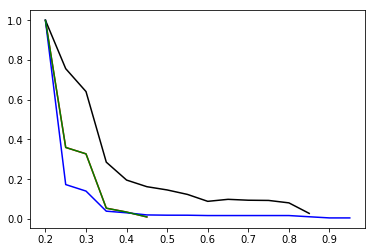

In [8]:
tcp_AB = mstis.transitions[(stateA, stateB)].tcp
tcp_AC = mstis.transitions[(stateA, stateC)].tcp
tcp_BC = mstis.transitions[(stateB, stateC)].tcp
tcp_BA = mstis.transitions[(stateB, stateA)].tcp
tcp_CA = mstis.transitions[(stateC, stateA)].tcp
tcp_CB = mstis.transitions[(stateC, stateB)].tcp

plt.plot(tcp_AB.x, tcp_AB, '-r')
plt.plot(tcp_CA.x, tcp_CA, '-k')
plt.plot(tcp_BC.x, tcp_BC, '-b')
plt.plot(tcp_AC.x, tcp_AC, '-g') # same as tcp_AB in MSTIS

We normally look at these on a log scale:

(0.0, 1.0)

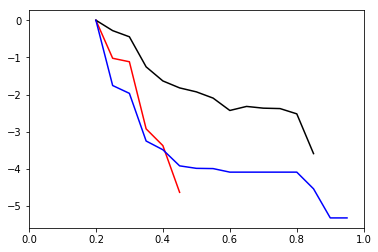

In [9]:
plt.plot(tcp_AB.x, np.log(tcp_AB), '-r')
plt.plot(tcp_CA.x, np.log(tcp_CA), '-k')
plt.plot(tcp_BC.x, np.log(tcp_BC), '-b')
plt.xlim(0.0, 1.0)

Now, in case you want to know the total crossing probabability at each interface (for example, to use as a bias in an SRTIS calculation):

In [10]:
# TODO: MOVE THESE TO A METHOD INSIDE THE CODE; MAKE THEM WORK WITH NEW ANALYSIS

In [11]:
import pandas as pd
def crossing_probability_table(transition):
    tcp = transition.tcp
    interface_lambdas = transition.interfaces.lambdas
    values = [tcp(x) for x in interface_lambdas]
    return pd.Series(values, index=interface_lambdas, name=transition.name)

In [12]:
def outer_crossing_probability(transition):
    tcp = transition.tcp
    interface_outer_lambda = transition.interfaces.lambdas[-1]
    return tcp(interface_outer_lambda)

In [13]:
crossing_probability_table(mstis.from_state[stateA])

0.2    1.000000
0.3    0.327398
0.4    0.034324
Name: Out A, dtype: float64

In [14]:
outer_crossing_probability(mstis.from_state[stateA])

0.03432399872756332

In [15]:
tcp_AB(mstis.from_state[stateA].interfaces.lambdas[-1])

0.03432399872756332

In [16]:
tcp_A = mstis.from_state[stateA].tcp

### Flux

Here we also calculate the flux contribution to each transition. The flux is calculated based on 

In [17]:
flux_dict = {
    (transition.stateA, transition.interfaces[0]): transition._flux
    for transition in mstis.transitions.values()
}
flux_dict

{(<openpathsampling.volume.CVDefinedVolume at 0x11c044978>,
  <openpathsampling.volume.CVDefinedVolume at 0x11c044a20>): 0.27223230490018147,
 (<openpathsampling.volume.CVDefinedVolume at 0x11c044ba8>,
  <openpathsampling.volume.CVDefinedVolume at 0x11ca83f28>): 0.20161290322580644,
 (<openpathsampling.volume.CVDefinedVolume at 0x11c044be0>,
  <openpathsampling.volume.CVDefinedVolume at 0x11caa03c8>): 0.4020100502512563}

In [18]:
paths.analysis.tis.flux_matrix_pd(flux_dict)

State  Interface  
A      0.0<opA<0.2    0.272232
B      0.0<opB<0.2    0.201613
C      0.0<opC<0.2    0.402010
Name: Flux, dtype: float64

### Conditional transition probability

In [19]:
state_names = [s.name for s in mstis.states]
outer_ctp_matrix = pd.DataFrame(columns=state_names, index=state_names)
for state_pair in mstis.transitions:
    transition = mstis.transitions[state_pair]
    outer_ctp_matrix.at[state_pair[0].name, state_pair[1].name] = transition.ctp[transition.ensembles[-1]]

outer_ctp_matrix

,A,B,C
A,NaN,0,0
B,0.440559,NaN,0.106893
C,0.0589411,0.26973,NaN


In [20]:
state_pair_names = [(t[0].name, t[1].name) for t in mstis.transitions]
ctp_by_interface = pd.DataFrame(index=state_pair_names)
for state_pair in mstis.transitions:
    transition = mstis.transitions[state_pair]
    for ensemble_i in range(len(transition.ensembles)):
        state_pair_name = (transition.stateA.name, transition.stateB.name)
        ctp_by_interface.at[state_pair_name, ensemble_i] = transition.conditional_transition_probability(
                storage.steps,
                transition.ensembles[ensemble_i]
        )
    
    
ctp_by_interface  

,0,1,2
"(A, B)",0.000000,0.000000,0.000000
"(A, C)",0.000000,0.000000,0.000000
"(B, A)",0.000000,0.000000,0.440559
"(B, C)",0.000000,0.000000,0.106893
"(C, A)",0.000000,0.000000,0.058941
"(C, B)",0.025974,0.022977,0.269730


## Path ensemble properties

In [21]:
hists_A = mstis.transitions[(stateA, stateB)].histograms
hists_B = mstis.transitions[(stateB, stateC)].histograms
hists_C = mstis.transitions[(stateC, stateB)].histograms

### Interface crossing probabilities

We obtain the total crossing probability, shown above, by combining the individual crossing probabilities of 

In [22]:
hists = {'A': hists_A, 'B': hists_B, 'C': hists_C}
plot_style = {'A': '-r', 'B': '-b', 'C': '-k'}

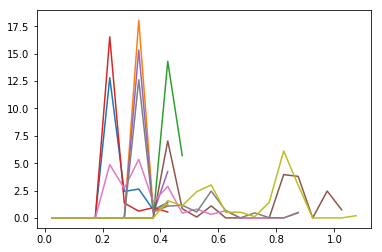

In [23]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['max_lambda']:
        normalized = hist['max_lambda'][ens].normalized()
        plt.plot(normalized.x, normalized)

In [24]:
# add visualization of the sum

(0.0, 1.0)

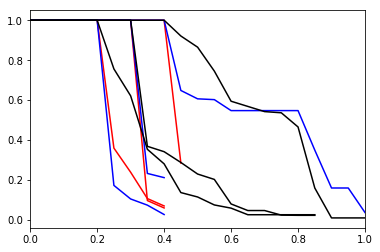

In [25]:
for hist_type in hists:
    hist = hists[hist_type]
    for ens in hist['max_lambda']:
        reverse_cumulative = hist['max_lambda'][ens].reverse_cumulative()
        plt.plot(reverse_cumulative.x, reverse_cumulative, plot_style[hist_type])
plt.xlim(0.0, 1.0)

(0.0, 1.0)

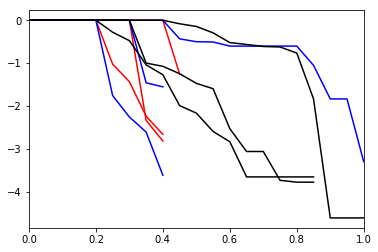

In [26]:
for hist_type in hists:
    hist = hists[hist_type]
    for ens in hist['max_lambda']:
        reverse_cumulative = hist['max_lambda'][ens].reverse_cumulative()
        plt.plot(reverse_cumulative.x, np.log(reverse_cumulative), plot_style[hist_type])
plt.xlim(0.0, 1.0)

### Path length histograms

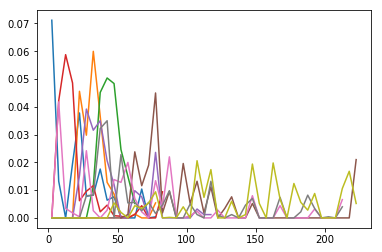

In [27]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['pathlength']:
        normalized = hist['pathlength'][ens].normalized()
        plt.plot(normalized.x, normalized)

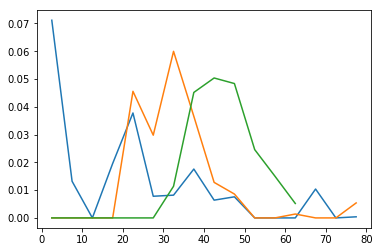

In [28]:
for ens in hists_A['pathlength']:
    normalized = hists_A['pathlength'][ens].normalized()
    plt.plot(normalized.x, normalized)

## Sampling properties

The properties we illustrated above were properties of the path ensembles. If your path ensembles are sufficiently well-sampled, these will never depend on how you sample them.

But to figure out whether you've done a good job of sampling, you often want to look at properties related to the sampling process. OPS also makes these very easy.

### Move scheme analysis

In [29]:
scheme = storage.schemes[0]

In [30]:
scheme.move_summary(storage.steps)

repex ran 21.600% (expected 22.39%) of the cycles with acceptance 44/216 (20.37%)
shooting ran 44.800% (expected 44.78%) of the cycles with acceptance 343/448 (76.56%)
pathreversal ran 27.000% (expected 24.88%) of the cycles with acceptance 250/270 (92.59%)
minus ran 2.400% (expected 2.99%) of the cycles with acceptance 23/24 (95.83%)
ms_outer_shooting ran 4.200% (expected 4.98%) of the cycles with acceptance 33/42 (78.57%)


In [31]:
scheme.move_summary(movers='shooting')

OneWayShootingMover Out A 0 ran 4.300% (expected 4.98%) of the cycles with acceptance 29/43 (67.44%)
OneWayShootingMover Out A 1 ran 4.400% (expected 4.98%) of the cycles with acceptance 38/44 (86.36%)
OneWayShootingMover Out A 2 ran 5.100% (expected 4.98%) of the cycles with acceptance 36/51 (70.59%)
OneWayShootingMover Out B 0 ran 6.100% (expected 4.98%) of the cycles with acceptance 51/61 (83.61%)
OneWayShootingMover Out B 1 ran 6.000% (expected 4.98%) of the cycles with acceptance 44/60 (73.33%)
OneWayShootingMover Out B 2 ran 5.100% (expected 4.98%) of the cycles with acceptance 34/51 (66.67%)
OneWayShootingMover Out C 0 ran 4.300% (expected 4.98%) of the cycles with acceptance 38/43 (88.37%)
OneWayShootingMover Out C 1 ran 5.600% (expected 4.98%) of the cycles with acceptance 45/56 (80.36%)
OneWayShootingMover Out C 2 ran 3.900% (expected 4.98%) of the cycles with acceptance 28/39 (71.79%)


In [32]:
scheme.move_summary(movers='minus')

Minus ran 0.600% (expected 1.00%) of the cycles with acceptance 6/6 (100.00%)
Minus ran 0.900% (expected 1.00%) of the cycles with acceptance 9/9 (100.00%)
Minus ran 0.900% (expected 1.00%) of the cycles with acceptance 8/9 (88.89%)


In [33]:
scheme.move_summary(movers='repex')

ReplicaExchange ran 2.200% (expected 2.49%) of the cycles with acceptance 7/22 (31.82%)
ReplicaExchange ran 2.400% (expected 2.49%) of the cycles with acceptance 0/24 (0.00%)
ReplicaExchange ran 2.300% (expected 2.49%) of the cycles with acceptance 2/23 (8.70%)
ReplicaExchange ran 1.900% (expected 2.49%) of the cycles with acceptance 2/19 (10.53%)
ReplicaExchange ran 2.100% (expected 2.49%) of the cycles with acceptance 14/21 (66.67%)
ReplicaExchange ran 3.000% (expected 2.49%) of the cycles with acceptance 7/30 (23.33%)
ReplicaExchange ran 2.600% (expected 2.49%) of the cycles with acceptance 0/26 (0.00%)
ReplicaExchange ran 3.100% (expected 2.49%) of the cycles with acceptance 6/31 (19.35%)
ReplicaExchange ran 2.000% (expected 2.49%) of the cycles with acceptance 6/20 (30.00%)


In [34]:
scheme.move_summary(movers='pathreversal')

PathReversal ran 2.800% (expected 2.49%) of the cycles with acceptance 28/28 (100.00%)
PathReversal ran 2.300% (expected 2.49%) of the cycles with acceptance 23/23 (100.00%)
PathReversal ran 2.600% (expected 2.49%) of the cycles with acceptance 26/26 (100.00%)
PathReversal ran 3.100% (expected 2.49%) of the cycles with acceptance 31/31 (100.00%)
PathReversal ran 2.100% (expected 2.49%) of the cycles with acceptance 21/21 (100.00%)
PathReversal ran 2.800% (expected 2.49%) of the cycles with acceptance 19/28 (67.86%)
PathReversal ran 2.500% (expected 2.49%) of the cycles with acceptance 24/25 (96.00%)
PathReversal ran 2.900% (expected 2.49%) of the cycles with acceptance 28/29 (96.55%)
PathReversal ran 2.700% (expected 2.49%) of the cycles with acceptance 18/27 (66.67%)
PathReversal ran 3.200% (expected 2.49%) of the cycles with acceptance 32/32 (100.00%)


### Replica exchange sampling

See the notebook `repex_networks.ipynb` for more details on tools to study the convergence of replica exchange. However, a few simple examples are shown here. All of these are analyzed with a separate object, `ReplicaNetwork`.

In [35]:
repx_net = paths.ReplicaNetwork(scheme, storage.steps)

#### Replica exchange mixing matrix

In [36]:
repx_net.mixing_matrix()

,11,6,7,8,12,5,4,3,10,9,0,1,2
11,0.000000,0.033333,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.0000,0.000,0.000000,0.000000,0.0
6,0.033333,0.000000,0.058333,0.000000,0.000,0.000000,0.000000,0.000000,0.0000,0.000,0.000000,0.000000,0.0
7,0.000000,0.058333,0.000000,0.029167,0.000,0.000000,0.000000,0.000000,0.0000,0.000,0.000000,0.000000,0.0
8,0.000000,0.000000,0.029167,0.000000,0.025,0.000000,0.000000,0.000000,0.0000,0.000,0.000000,0.000000,0.0
12,0.000000,0.000000,0.000000,0.025000,0.000,0.025000,0.000000,0.000000,0.0000,0.000,0.000000,0.000000,0.0
5,0.000000,0.000000,0.000000,0.000000,0.025,0.000000,0.008333,0.000000,0.0000,0.000,0.000000,0.000000,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000,0.008333,0.000000,0.008333,0.0000,0.000,0.000000,0.000000,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.008333,0.000000,0.0375,0.000,0.000000,0.000000,0.0
10,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.037500,0.0000,0.000,0.000000,0.000000,0.0
9,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.0000,0.000,0.025000,0.000000,0.0


#### Replica exchange graph

The mixing matrix tells a story of how well various interfaces are connected to other interfaces. The replica exchange graph is essentially a visualization of the mixing matrix (actually, of the transition matrix -- the mixing matrix is a symmetrized version of the transition matrix).

Note: We're still developing better layout tools to visualize these.

/Users/dwhs/miniconda3/envs/dev/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


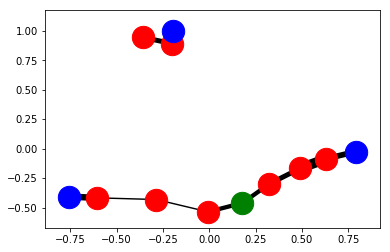

In [37]:
repxG = paths.ReplicaNetworkGraph(repx_net)
repxG.draw('spring')

#### Replica exchange flow

Replica flow is defined as ***TODO***

Flow is designed for calculations where the replica exchange graph is linear, which ours clearly is not. However, we can define the flow over a subset of the interfaces.

### Replica move history tree

In [38]:
import openpathsampling.visualize as vis
from IPython.display import SVG

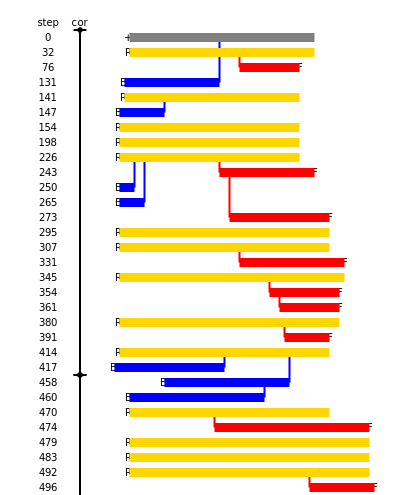

In [39]:
tree = vis.PathTree(
    storage.steps[0:500],
    vis.ReplicaEvolution(replica=2, accepted=True)
)

SVG(tree.svg())

In [40]:
decorrelated = tree.generator.decorrelated
print("We have " + str(len(decorrelated)) + " decorrelated trajectories.")

We have 2 decorrelated trajectories.


### Visualizing trajectories

In [41]:
# we use the %run magic because this isn't in a package
%run ../resources/toy_plot_helpers.py
background = ToyPlot()
background.contour_range = np.arange(-1.5, 1.0, 0.1)
background.add_pes(storage.engines[0].pes)

<Figure size 432x288 with 0 Axes>

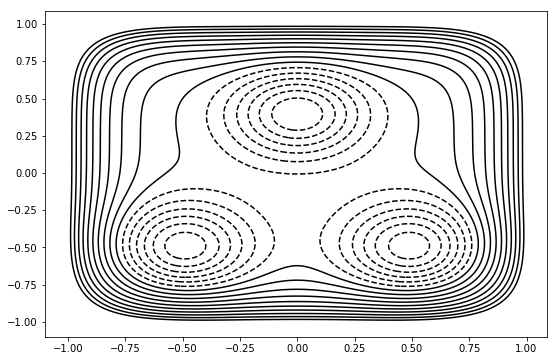

In [42]:
xval = paths.FunctionCV("xval", lambda snap : snap.xyz[0][0])
yval = paths.FunctionCV("yval", lambda snap : snap.xyz[0][1])
visualizer = paths.StepVisualizer2D(mstis, xval, yval, [-1.0, 1.0], [-1.0, 1.0])
visualizer.background = background.plot()

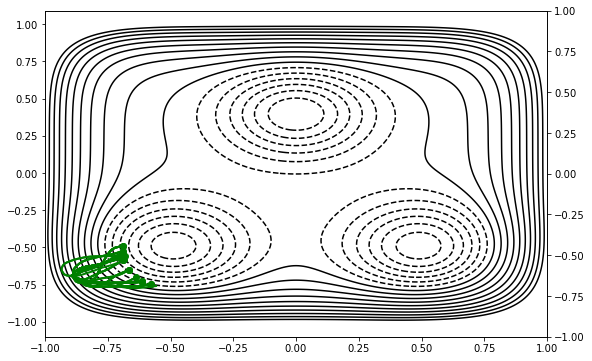

In [43]:
visualizer.draw_samples(list(tree.samples))

## Histogramming data (TODO)

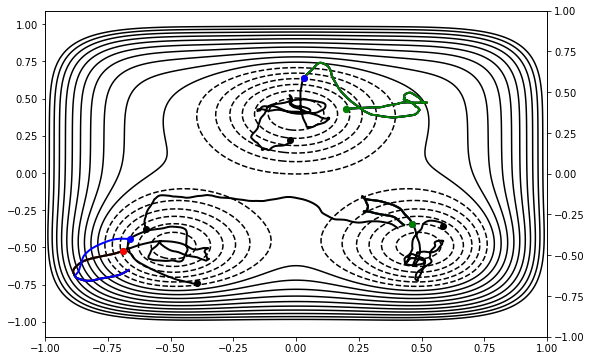

In [44]:
#! skip
# The skip directive tells our test runner not to run this cell
import time
max_step = 10
for step in storage.steps[0:max_step]:
    visualizer.draw_ipynb(step)
    time.sleep(0.1)